(540, 2500) (540,)


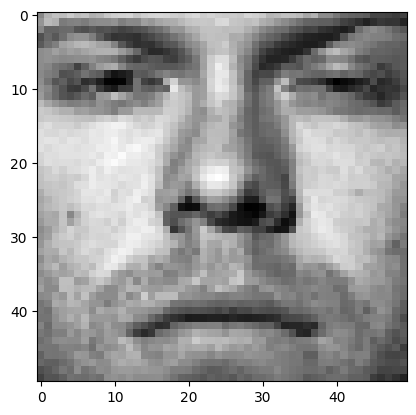

In [8]:
import numpy as np
from PIL import Image
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = np.array(Image.open(line.strip().split()[0]).convert('L'))
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

## Average Face

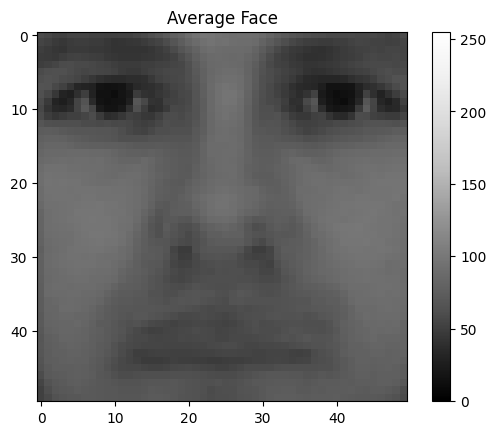

In [9]:
# Display the average face
mu = np.sum(train_data, axis=0) / train_data.shape[0]
plt.figure()
plt.imshow(mu.reshape(50, 50), cmap=cm.Greys_r, vmin=0, vmax=255)
plt.title('Average Face')
plt.colorbar()
plt.show()

## Mean Subtraction

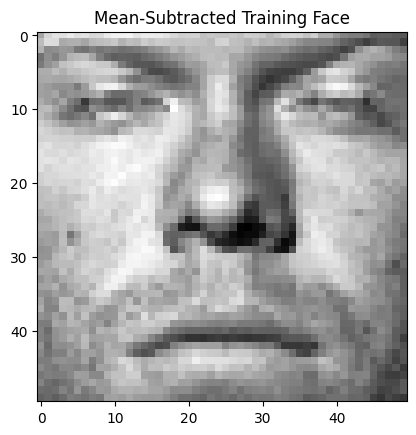

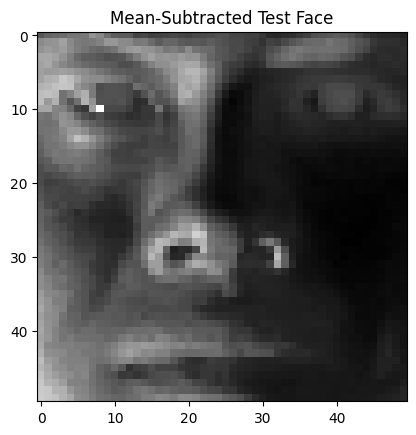

In [ ]:
train_data = train_data - mu

plt.figure()
plt.imshow(train_data[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title('Mean-Subtracted Training Face')
plt.show()

test_labels, test_data = [], []
for line in open('./faces/test.txt'):
  im = np.array(Image.open(line.strip().split()[0]).convert('L'))
  test_data.append(im.reshape(2500,))
  test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

test_data = test_data - mu

# Display a mean-subtracted test image
plt.figure()
plt.imshow(test_data[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title('Mean-Subtracted Test Face')
plt.show()

## Eigenface

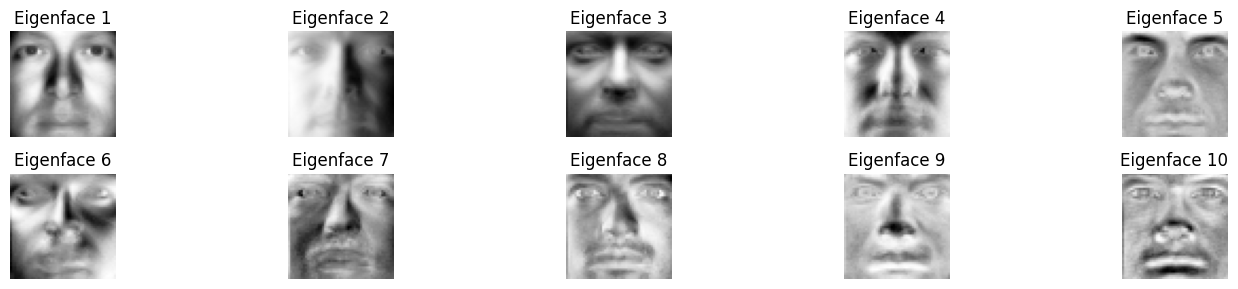

In [11]:
# Compute X^T X (covariance matrix)
XTX = np.dot(train_data.T, train_data)

# Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(XTX)

# Take real parts to handle any numerical precision issues
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Sort by eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# V^T where each row is an eigenface
VT = eigenvectors.T

# Display the first 10 eigenfaces
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(VT[i, :].reshape(50, 50), cmap=cm.Greys_r)
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def extract_features(data, VT, r):
    """
    Extract r-dimensional features from face data using top r eigenfaces

    data: face images matrix (n_samples, 2500)
    VT: eigenfaces matrix (2500, 2500), each row is an eigenface
    r: number of eigenfaces to use

    Returns: feature matrix (n_samples, r)
    """
    F = np.dot(data, VT[:r, :].T)
    return F

In [ ]:
# Extract features with r=10
r = 10
F = extract_features(train_data, VT, r)
Ftest = extract_features(test_data, VT, r)

print(f"F shape: {F.shape}")
print(f"Ftest shape: {Ftest.shape}")

F shape: (540, 10)
Ftest shape: (100, 10)


## Face Recognition

/Users/igb/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/igb/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/igb/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/igb/Library/Python/3.11/lib/python/site-packages/sklearn/linear

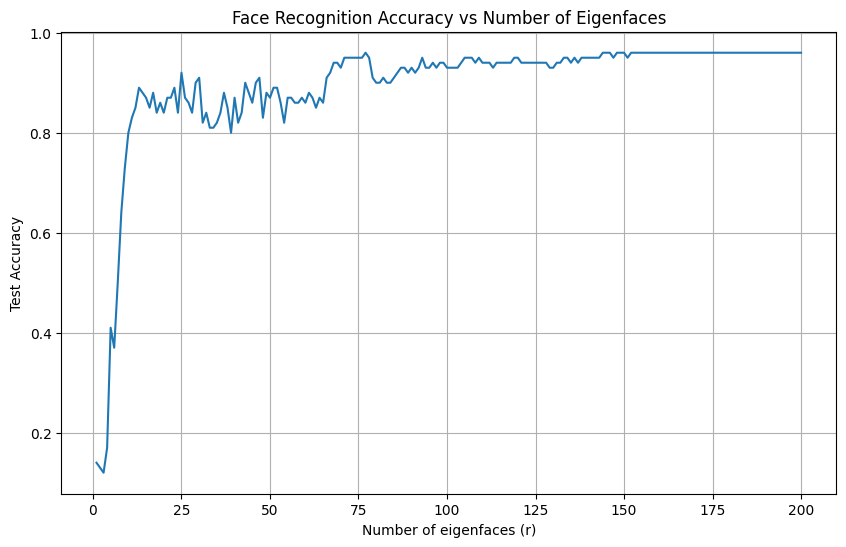

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# List to store accuracies
accuracies = []

# Loop through r values from 1 to 200
for r in range(1, 201):  # range(1, 201) gives you 1, 2, 3, ..., 200

    # Extract r-dimensional features
    F = extract_features(train_data, VT, r)
    Ftest = extract_features(test_data, VT, r)

    # Train logistic regression
    model = LogisticRegression(multi_class='ovr')
    model.fit(F, train_labels)

    # Make predictions
    predictions = model.predict(Ftest)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)

    # Store the accuracy
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), accuracies)
plt.xlabel('Number of eigenfaces (r)')
plt.ylabel('Test Accuracy')
plt.title('Face Recognition Accuracy vs Number of Eigenfaces')
plt.grid(True)
plt.show()

## Low-Rank Data Loss

Completed r=50, distance=13637.64
Completed r=100, distance=9335.57
Completed r=150, distance=7124.02
Completed r=150, distance=7124.02
Completed r=200, distance=5608.17
Completed r=200, distance=5608.17


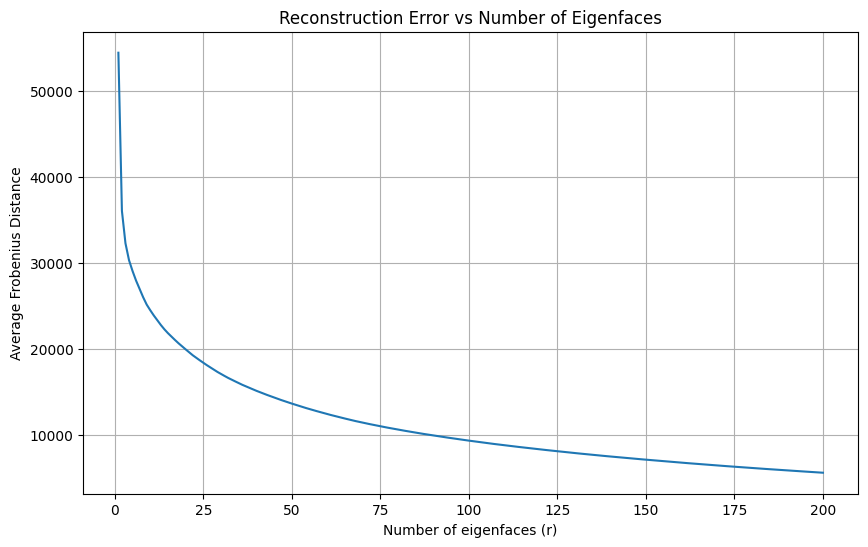

In [ ]:
# List to store Frobenius distances
distances = []

# Loop through r values from 1 to 200
for r in range(1, 201):

    # Extract r-dimensional features for training data
    F = extract_features(train_data, VT, r)

    # Reconstruct X' from F
    X_prime = F @ VT[:r, :]

    # Calculate Frobenius distance between original and reconstructed data
    distance = np.linalg.norm(train_data - X_prime, 'fro')

    # Store the distance
    distances.append(distance)

    # Optional: print progress every 50 iterations
    if r % 50 == 0:
        print(f"Completed r={r}, distance={distance:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), distances)
plt.xlabel('Number of eigenfaces (r)')
plt.ylabel('Average Frobenius Distance')
plt.title('Reconstruction Error vs Number of Eigenfaces')
plt.grid(True)
plt.show()